# Twitter Sentiment Analysis
Abrar Habib, CSc447

In [48]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from concurrent.futures import ProcessPoolExecutor
from sklearn.metrics import classification_report, accuracy_score

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/abrar/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/abrar/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/abrar/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/abrar/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/abrar/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]   

True

In [49]:
# Limiting to only the first 1000 rows because there are a lot of tweets.
header = ["target", "ids", "date", "flag", "user", "text"]
nRowsRead = None
df = pd.read_csv('./data/sentiment140.csv', delimiter=',', nrows=nRowsRead, header=None, names=header)
df = df.sample(frac=1).reset_index(drop=True)
df

,target,ids,date,flag,user,text
0,4,2001290372,Tue Jun 02 00:24:41 PDT 2009,NO_QUERY,smithsocksimon,Tour de Suisse passes through Winterthur with...
1,4,2016823551,Wed Jun 03 07:25:08 PDT 2009,NO_QUERY,Raenichols,is in Widnes. And gets to do her dissertation ...
2,0,1687527894,Sun May 03 08:56:05 PDT 2009,NO_QUERY,bertobi,my lecturer sux - not helping me do my concre...
3,4,1980760837,Sun May 31 07:36:18 PDT 2009,NO_QUERY,zoja87,@jakub_zalas lazy sathurday followed by lazy s...
4,4,1563956665,Mon Apr 20 01:03:03 PDT 2009,NO_QUERY,EveD,"I must be a nerd, not a geek, because I love t..."
...,...,...,...,...,...,...
1599995,4,1982117684,Sun May 31 10:33:47 PDT 2009,NO_QUERY,Hogansterrx,@Dannymcfly GOOD LUCK DANNY !x Not Like You Ne...
1599996,0,2207061041,Wed Jun 17 07:25:57 PDT 2009,NO_QUERY,MaggieConv,had to get a sugar free hazelnut latte this mo...
1599997,0,1996517420,Mon Jun 01 15:13:05 PDT 2009,NO_QUERY,krisshuntx3,@christina_savs awwww that's so mean! not the ...
1599998,0,1557256180,Sun Apr 19 02:57:59 PDT 2009,NO_QUERY,strangetimes87,REALLY hopes he'll play &quot;I Come Running&q...


## Preprocess text

Side note: Wanted to see what the stop words were. Pretty interesting to see certain words that are considered stop words. I would have thought the words "wouldn't" and "won't" would be meaningful to a sentence, but this library considers them to be stop words.

In [50]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [51]:
def preprocess_text(text):
    # tokenize text
    tokens = word_tokenize(text.lower())
    
    # remove stopwords
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    # lemmatize text
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # join the tokens back into a string
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

# apply the preprocess_text function to the 'text' column

def process_chunk(chunk, func):
    """Process a chunk of the DataFrame column with the given function."""
    return chunk.apply(func)

def parallel_apply(df, func, column_name, num_processes):
    """
    Apply a function to a specific column of a DataFrame in parallel.

    Args:
    - df (pd.DataFrame): The DataFrame to process.
    - func (callable): The function to apply to each element of the column.
    - column_name (str): The name of the column to process.
    - num_processes (int): Number of processes to use.

    Returns:
    - pd.Series: The processed column as a Series.
    """
    # Split the column into chunks
    chunks = np.array_split(df[column_name], num_processes)

    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        # Apply the function to each chunk in parallel
        processed_chunks = list(executor.map(process_chunk, chunks, [func] * len(chunks)))

    # Concatenate processed chunks back into a single Series
    return pd.concat(processed_chunks)

# Example Usage
df['processed_text'] = parallel_apply(df, preprocess_text, 'text', num_processes=4)

In [57]:
df.to_csv('./data/sentiment140_processed.csv', index=False)

In [52]:
# for train-test split
X = df['processed_text']
y = df['target']


In [53]:
# use either of the two vectorizers to transform the text data

vectorizer = TfidfVectorizer(max_features=1000) # adjust the max_features to get better results
X_vectorized = vectorizer.fit_transform(X)

In [54]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [55]:
# train the naive bayes classifier

model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [56]:
# Evaluate the model

y_pred = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

Accuracy:  0.735953125
Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.72      0.73    160231
           4       0.73      0.75      0.74    159769

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000



In [64]:
def predict_sentiment(tweet, model, vectorizer):
    # Preprocess the tweet
    processed_tweet = preprocess_text(tweet)
    
    # Vectorize the preprocessed tweet
    vectorized_tweet = vectorizer.transform([processed_tweet])
    
    # Predict the sentiment of the tweet
    sentiment = model.predict(vectorized_tweet)[0]
    sentiment_dict = {0: 'Negative', 2: 'Neutral', 4: 'Positive'}
    sentiment = sentiment_dict[sentiment]
    return sentiment

# Example Usage
tweet = "I went to the store."
sentiment = predict_sentiment(tweet, model, vectorizer)
print(sentiment)


Negative


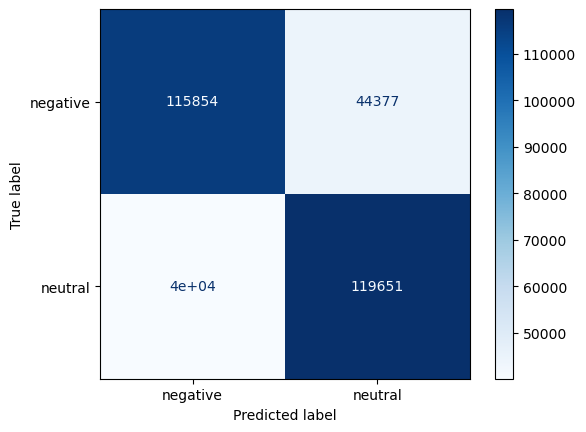

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have the true labels y_true and predictions y_pred
y_true = y_test  # Replace with your true labels for the test set
y_pred = model.predict(X_test)  # Replace with your predicted labels

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Determine the number of classes present in the confusion matrix
n_classes = cm.shape[0]

# Update display labels based on the number of classes
display_labels = ['negative', 'neutral', 'positive'][:n_classes]  # Adjust to match number of classes

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues')
